# Building a Recommender System from Scratch

### Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load Data

We will be using different versions of the [MovieLens dataset](https://grouplens.org/datasets/movielens/), mainly `ml-latest-small.zip`:

- ratings.csv
- movies.csv


In [7]:
ratings = pd.read_csv('./data/ratings.csv')

In [8]:
ratings.head(20)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [9]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
5,1,70,3.0,2000-07-30 18:40:00
6,1,101,5.0,2000-07-30 18:14:28
7,1,110,4.0,2000-07-30 18:36:16
8,1,151,5.0,2000-07-30 19:07:21
9,1,157,5.0,2000-07-30 19:08:20


In [10]:
movies = pd.read_csv('./data/movies.csv')

In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis

- Mean_ratings_per_user
- Mean_ratings_per_movie
- Best vs. Worst Movie

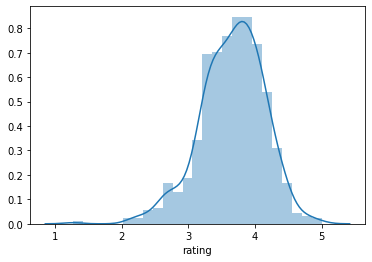

In [13]:
sns.distplot(ratings.groupby('userId').rating.mean())

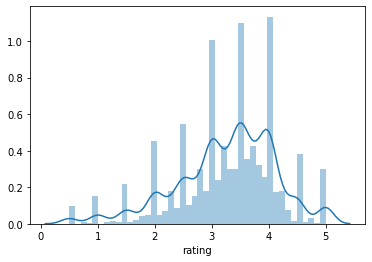

In [14]:
sns.distplot(ratings.groupby('movieId').rating.mean())

In [18]:
ratings.movieId.nunique()

9724

In [19]:
ratings.userId.nunique()

610

In [21]:
len(ratings)

100836

In [22]:
mean_ratings = ratings.groupby('movieId').rating.mean()

In [25]:
mean_ratings

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [23]:
mean_ratings.idxmax()

53

In [24]:
mean_ratings.idxmin()

3604

In [28]:
movies[movies.movieId == mean_ratings.idxmax()]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [27]:
movies[movies.movieId == mean_ratings.idxmin()]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [29]:
ratings[ratings.movieId == mean_ratings.idxmax()]

,userId,movieId,rating,timestamp
13368,85,53,5.0,1998-03-09 18:31:08
96115,603,53,5.0,2000-07-09 22:00:03


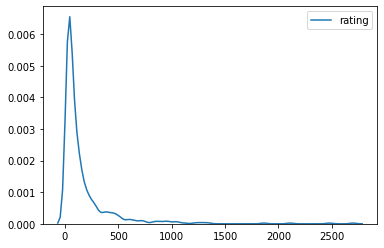

In [33]:
sns.kdeplot(ratings.groupby('userId').rating.count())

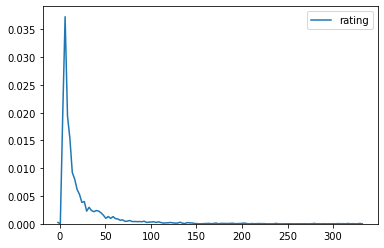

In [32]:
sns.kdeplot(ratings.groupby('movieId').rating.count())

#### Bayesian Average

Bayesian average is a method of estimating the mean of a population using outside information, especially a pre-existing belief, that is factored into the calculation. This is a central feature of Bayesian interpretation. This is useful when the available data set is small.

Calculating the Bayesian average uses the prior mean m and a constant C. C is chosen based on the typical data set size required for a robust estimate of the sample mean. The value is larger when the expected variation between data sets (within the larger population) is small. It is smaller when the data sets are expected to vary substantially from one another. 

$r_{i} = \frac{C \times m + \Sigma{\text{ratings}}}{C+N}$

In this case, our prior will be the average rating across all movies. Let's make $C$ be the average number of ratings for a given movie. $N$ is the total number of reviews for movie $i$.

In [37]:
C = ratings.groupby('movieId').rating.count().mean()

In [42]:
m = ratings.groupby('movieId').rating.mean().mean()

In [47]:
bayesian_avg = (C*m +ratings.groupby('movieId').rating.sum()) / (C+ratings.groupby('movieId').rating.count() )

In [50]:
movies[movies.movieId == bayesian_avg.idxmax()]

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama


In [51]:
movies[movies.movieId == bayesian_avg.idxmin()]

,movieId,title,genres
1173,1556,Speed 2: Cruise Control (1997),Action|Romance|Thriller


In [20]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])

In [21]:
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [23]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense.

### Data Pre-processing

We will be using colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="https://www.researchgate.net/profile/Tommaso_Di_Noia/publication/300646445/figure/fig2/AS:360201661239310@1462890176315/Example-of-user-item-ratings-matrix-in-a-movie-recommendation-scenario.png" width=60%/>

In [55]:
utility_matrix = ratings[['userId', 'movieId', 'rating']].pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [56]:
utility_matrix.shape

(610, 9724)

In [58]:
from scipy.sparse import csr_matrix

In [60]:
X = csr_matrix(utility_matrix)

In [61]:
X

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [62]:
X.getnnz()

100836

In [30]:
utility_matrix = ratings[['userId', 'movieId', 'rating']].pivot_table(index='userId', values='rating', columns='movieId').fillna(0)

In [31]:

X = csr_matrix(ratings[['userId', 'movieId', 'rating']].pivot_table(index='userId', values='rating', columns='movieId').fillna(0))

#### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix is equivalent to the number of ratings in our dataset.

`csr_matrix.nnz` or `csr_matrix.getnnz()` counts the stored values in our sparse matrix. The rest of our cells are empty.

In [63]:
n_total = np.prod(X.shape)
n_ratings = X.getnnz()
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [64]:
movie_ids = (utility_matrix.columns)
user_ids = (utility_matrix.index)

In [66]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [67]:
movies.set_index('movieId', inplace=True, drop=False)

In [68]:
movies

,movieId,title,genres
movieId,,,
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
193581,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,193585,Flint (2017),Drama


#### Normalizing our data

User-item bias is defined as: $b_{ui} = \mu + b_{u} + b_{i}$

We will perform mean normalization by subtracting $b_{i}$ from each movie's rating.

In [69]:
sum_ratings_per_movie = X.sum(axis=0)
n_ratings_per_movie = X.getnnz(axis=0)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie

In [71]:
mean_rating_per_movie.shape

(1, 9724)

Now that we have the mean rating for each movie, we are going to subtract this from our utility matrix. In order to do this, we need to expand our 1D `mean_rating_per_movie` array into a matrix with the same shape as our utility matrix `(n_users, n_movies)`. Numpy's `tile` method is useful for this task.

In [75]:
(X.shape[0],1)

(610, 1)

In [72]:
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1))

In [73]:
X_mean_movie.shape

(610, 9724)

`X_mean_movie` is a matrix of shape (n_users, n_movies) in which each column is populated with a given movie's mean rating.

We can easily normalize our X matrix by subtracting `X_mean_movie` from original `X`.

In [74]:
X_norm = X - csr_matrix(X_mean_movie)

As expected, `X_norm`'s values are different from `X`s. Cells that are empty in the original matrix are now replaced with negative values representing the mean rating of a given movie. 

In [76]:
X

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [77]:
X.todense()

matrix([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [78]:
X_norm.todense()

matrix([[ 0.07906977, -3.43181818,  0.74038462, ..., -3.5       ,
         -3.5       , -4.        ],
        [-3.92093023, -3.43181818, -3.25961538, ..., -3.5       ,
         -3.5       , -4.        ],
        [-3.92093023, -3.43181818, -3.25961538, ..., -3.5       ,
         -3.5       , -4.        ],
        ...,
        [-1.42093023, -1.43181818, -1.25961538, ..., -3.5       ,
         -3.5       , -4.        ],
        [-0.92093023, -3.43181818, -3.25961538, ..., -3.5       ,
         -3.5       , -4.        ],
        [ 1.07906977, -3.43181818, -3.25961538, ..., -3.5       ,
         -3.5       , -4.        ]])

### Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [5]:
from sklearn.neighbors import NearestNeighbors


In [43]:
def similar_movies(title):

    return similar_movies

In [44]:
similar_movies('Godfather')

,movieId,title,genres,genre,year
movieId,,,,,
858,858,"Godfather, The",Crime|Drama,Crime,1972
1089,1089,Reservoir Dogs,Crime|Mystery|Thriller,Crime,1992
1193,1193,One Flew Over the Cuckoo's Nest,Drama,Drama,1975
1201,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,Action,1966
1208,1208,Apocalypse Now,Action|Drama|War,Action,1979
1213,1213,Goodfellas,Crime|Drama,Crime,1990
1219,1219,Psycho,Crime|Horror,Crime,1960
1221,1221,"Godfather: Part II, The",Crime|Drama,Crime,1974
1228,1228,Raging Bull,Drama,Drama,1980


You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [45]:
def best_movies(userId, k=10):
    return movies

In [46]:
best_movies(0,10)

,movieId,title,genres,genre,year
movieId,,,,,
216,216,Billy Madison,Comedy,Comedy,1995
940,940,"Adventures of Robin Hood, The",Action|Adventure|Romance,Action,1938
1240,1240,"Terminator, The",Action|Sci-Fi|Thriller,Action,1984
1256,1256,Duck Soup,Comedy|Musical|War,Comedy,1933
1270,1270,Back to the Future,Adventure|Comedy|Sci-Fi,Adventure,1985
1275,1275,Highlander,Action|Adventure|Fantasy,Action,1986
1278,1278,Young Frankenstein,Comedy|Fantasy,Comedy,1974
2078,2078,"Jungle Book, The",Animation|Children|Comedy|Musical,Animation,1967
3034,3034,Robin Hood,Adventure|Animation|Children|Comedy|Musical,Adventure,1973


In [47]:
def recommend_by_similar_movies(id):

    return similar_movies      

In [48]:
recommend_by_similar_movies(0)

,movieId,title,genres,genre,year
movieId,,,,,
146,146,"Amazing Panda Adventure, The",Adventure|Children,Adventure,1995
255,255,"Jerky Boys, The",Comedy,Comedy,1995
313,313,"Swan Princess, The",Animation|Children,Animation,1994
405,405,Highlander III: The Sorcerer (a.k.a. Highlande...,Action|Fantasy,Action,1994
484,484,Lassie,Adventure|Children,Adventure,1994
520,520,Robin Hood: Men in Tights,Comedy,Comedy,1993
562,562,Welcome to the Dollhouse,Comedy|Drama,Comedy,1995
569,569,Little Big League,Comedy|Drama,Comedy,1994
946,946,To Be or Not to Be,Comedy|Drama|War,Comedy,1942


In [49]:
def similar_users(id):

    return users

In [50]:
similar_users(0)

array([492,  38, 493, 207, 179, 393, 163,  95, 230, 398])

In [51]:
def recommend_by_similar_users(id):

    return movies

In [52]:
recommend_by_similar_users(0)

,movieId,title,genres,genre,year
movieId,,,,,
34,34,Babe,Children|Drama,Children,1995
150,150,Apollo 13,Adventure|Drama|IMAX,Adventure,1995
225,225,Disclosure,Drama|Thriller,Drama,1994
272,272,"Madness of King George, The",Comedy|Drama,Comedy,1994
380,380,True Lies,Action|Adventure|Comedy|Romance|Thriller,Action,1994
589,589,Terminator 2: Judgment Day,Action|Sci-Fi,Action,1991
858,858,"Godfather, The",Crime|Drama,Crime,1972
1036,1036,Die Hard,Action|Crime|Thriller,Action,1988
1200,1200,Aliens,Action|Adventure|Horror|Sci-Fi,Action,1986


### Dimensionality Reduction with Matrix Factorization (Model based)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$
<img src="images/matrix-factorization.png" width="50%"/>

In [53]:
from sklearn.decomposition import TruncatedSVD


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=30. We can think of each component representing a latent feature such as movie genre.

#### Predicting missing ratings to generate top N recommendations

With matrix factorization, we can also predict missing ratings in our original user-item matrix. We can do this by reconstructing our matrix by getting the inner product of our user-factor matrix and movie-factor matrix. We can use the `inverse_transform` on our movie-factor matrix Z to get our reconstructed user-item matrix.

Let’s look at `userId=100`’s recommendations. In the table below, we can see which movies that have been rated highly:

In [55]:
def recomendaciones(userId, k=10):

    return movies

In [56]:
recomendaciones(100)

,movie,rating,pred
1938,"Walk on the Moon, A",0.0,1.233874
1403,Whatever,0.0,0.875737
1297,Mr. Magoo,0.0,0.868301
827,Dirty Dancing,0.0,0.837578
1733,Vampires,0.0,0.801190
1182,Fall,0.0,0.796141
1502,Jane Austen's Mafia!,0.0,0.795637
613,Trainspotting,0.0,0.766051
1283,For Richer or Poorer,0.0,0.751770
3136,"Longest Yard, The",0.0,0.749209


### Using NMF

In [57]:
from sklearn.decomposition import NMF

In [ ]:
def recomendaciones(userId, k=10):

    return movies

In [59]:
recomendaciones(120)

,movie,rating,pred
418,Jurassic Park,0.0,2.237007
510,"Silence of the Lambs, The",0.0,2.173045
138,Die Hard: With a Vengeance,0.0,1.988764
322,"Lion King, The",0.0,1.967379
506,Aladdin,0.0,1.957672
507,Terminator 2: Judgment Day,0.0,1.846749
31,Twelve Monkeys (a.k.a. 12 Monkeys),0.0,1.828117
546,Mission: Impossible,0.0,1.645668
436,Mrs. Doubtfire,0.0,1.637723
594,Twister,0.0,1.626862
